# **Laboratorium ADOM 5 i 6 - ZALICZENIE**
---


Tu wpisz swoje: imię nazwisko i numer indeksu:

# Kamil Grzegorzewski, 284982

Znajdż najlepszy klasyfikator realizujący zadanie klasyfikacji 6 symboli znajdujących się na obrazach `obiekty` i `obiekty2`. Pierwszy obraz potraktuj jako źródło danych dla zbioru uczącego, zaś drugi - dla testowego. **UWAGA:** Prawidłowa detekcja klasy obiektu powinna przebiegać także dla obiektów obróconych o 90, 180 i 270 stopni i poddanym odbiciom lustrzanym. Zaproponuj metodę augmentacji danych uczących oraz sposób prezentacji wyników dla obiektów poddanych obrotom i odbiciom (w obu zbiorach). W skrypcie zamieść kod **najlepszego** klasyfikatora (= o najwyższej dokładności na zbiorze testowym, przy jednocześnie najmniejszej liczbie paramterów uczenia, tj. wag sieci), jaki udało się opracować.

## Skrypty wstępne (wczytanie pakietów itp.)

In [1]:
# zadania wstępne (wczytanie pakietów itp.)
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

from skimage.measure import label,regionprops

from sklearn.model_selection import train_test_split

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

def pokaz(obraz, tytul = "", osie = False, openCV = True, colmap = 'gray'):
    if not(osie):
        plt.axis("off") 
    if obraz.ndim == 2:
        plt.imshow(obraz,cmap = colmap,vmin=0, vmax=255)
    else:
        if openCV:
            plt.imshow(cv2.cvtColor(obraz,cv2.COLOR_BGR2RGB),vmin=0, vmax=255)
        else:
            plt.imshow(obraz,interpolation = 'none',vmin=0, vmax=255)
    plt.title(tytul)

def polob(listaobr, ile_k = 1, listatyt = [], openCV = True, wart_dpi = 100, osie = False, colmap = 'gray'):
    rozm_obr = 5
    ile = len(listaobr)
    if len(listatyt) == 0:
        listatyt = [' ']*ile
    ile_w = np.ceil(ile / ile_k).astype(int)
    figsize_k = rozm_obr*ile_k
    figsize_w = rozm_obr*ile_w
    plt.figure(figsize=(figsize_k,figsize_w), dpi = wart_dpi)
    for i in range(0,ile):
        if isinstance(listaobr[i],np.ndarray):
            plt.subplot(ile_w,ile_k,i+1)
            pokaz(listaobr[i],listatyt[i],osie,openCV, colmap)
    plt.show()
    
def ekstrakcja_cech(o):
    # ekstrakcja cech
    # binaryzacja obrazu
    b = cv2.inRange(o,(1,1,1),(255,255,255))
    # etykietowanie i ekstrakcja cech
    cechy = regionprops(label(b))
    ile_obiektow = len(cechy)
    lista_cech = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent','EquivDiameter','Solidity']
    ile_cech = len(lista_cech)
    tabela_cech = np.zeros((ile_obiektow,ile_cech+1+7)) # "1" - to jedna cecha wyliczna, "7" to momenty Hu
    listaob = []
    for i in range(0,ile_obiektow):
        yp,xp,yk,xk = cechy[i]['BoundingBox']
        aktualny_obiekt = o[yp:yk,xp:xk,:]
        ret,binobj = cv2.threshold(aktualny_obiekt[:,:,1],0,255,cv2.THRESH_BINARY)      
        listaob.append(binobj) #aktualny_obiekt)
        # rejestrujemy wybrane cechy wyznaczone przez regionprops
        for j in range(0,ile_cech):
            tabela_cech[i,j] = cechy[i][lista_cech[j]]
        # dodajemy momenty Hu   
        hu = cv2.HuMoments(cv2.moments(binobj))
        hulog = (1 - 2*(hu>0).astype('int'))* np.nan_to_num(np.log10(np.abs(hu)),copy=True,neginf=-99,posinf=99)
        tabela_cech[i,ile_cech+1:ile_cech+8] = hulog.flatten()
    tabela_cech[:,ile_cech] = tabela_cech[:,3]/tabela_cech[:,2] # cecha wyliczana
    tabela_cech[:,0] = (tabela_cech[:,0] == 1) # korekta liczby Eulera
    return listaob, tabela_cech


def ekstrakcja_klas(o):
    # ekstrakcja kategorii
    # binaryzacja obrazu
    b = cv2.inRange(o,(1,1,1),(255,255,255))
    # etykietowanie i ekstrakcja cech
    cechy = regionprops(label(b))
    ile_obiektow = len(cechy)
    # wyszukiwanie kolorów
    kolory = np.unique(o.reshape(-1, o.shape[2]), axis=0) # kolory w obrazie
    # według kolorów przypiszemy klasy obiektom
    kolory = kolory[1:7,:] # usuwa kolor tła
    ile_kategorii = len(kolory)
    kategorie = np.zeros((ile_obiektow,1)).astype('int')
    listaob = []
    for i in range(0,ile_obiektow):
        x,y = cechy[i]['Coordinates'][1] # wsp. jednego z punktów obiektu - do próbkowania koloru
        for k in range(0,ile_kategorii):
            if list(o[x,y,:]) == list(kolory[k]):
                break;
        kategorie[i] = k 
    return kategorie

def wybierz(tabela_cech,lista_cech):
    wybrane =  np.zeros((tabela_cech.shape[0],len(lista_cech)))
    for i in range(0,len(lista_cech)):
        wybrane[:,i] = tabela_cech[:,lista_cech[i]]
    return wybrane

def testuj(model,wybrane_cechy):
    print("wybrane cechy")
    cechy = ['EulerNumber','Area','BoundingBoxArea','FilledArea','Extent',
                               'EquivDiameter','Solidity','ExtentNoHoles',"log Hu1","log Hu2",
                               "log Hu3","log Hu4","log Hu5","log Hu6","log Hu7"]
    lista_cech = [cechy[i] for i in wybrane_cechy]
    print(lista_cech)
    o = cv2.imread("obiekty.png")
    o2 = cv2.imread("obiekty2.png")  
    o3 = cv2.imread("obiekty3.png")
    polob([o,o2,o3],3)
    lo, tc = ekstrakcja_cech(o)
    ka = ekstrakcja_klas(o)
    lo2, tc2 = ekstrakcja_cech(o2)
    ka2 = ekstrakcja_klas(o2)
    lo3, tc3 = ekstrakcja_cech(o3)  
    wc = wybierz(tc,wybrane_cechy)
    wc2 = wybierz(tc2,wybrane_cechy)
    wc3 = wybierz(tc3,wybrane_cechy)    
    model.fit(wc,np.ravel(ka))
    klasy_przewidywane = model.predict(wc)
    mp = confusion_matrix(klasy_przewidywane,ka)
    print("macierz pomyłek - zbiór uczący, dokładność:",np.sum(np.diag(mp))/np.sum(mp))
    print(mp)
    klasy_przewidywane2 = model.predict(wc2)
    mp2 = confusion_matrix(klasy_przewidywane2,ka2)
    print("macierz pomyłek - zbiór testowy, dokładność:",np.sum(np.diag(mp2))/np.sum(mp2))
    print(mp2)
    klasy_przewidywane3 = model.predict(wc3)
    print("klasyfikacja nieznanych danych")
    for j in range(6):
        lista_klasy = [lo3[i] for i in np.where(klasy_przewidywane3 == j)[0]]
        print("klasa:",j," obiektów:", len(lista_klasy))
        polob(lista_klasy,15,colmap='winter')

## Wczytanie oraz przetwarzanie obrazów, ekstrakcja danych, prezentacja

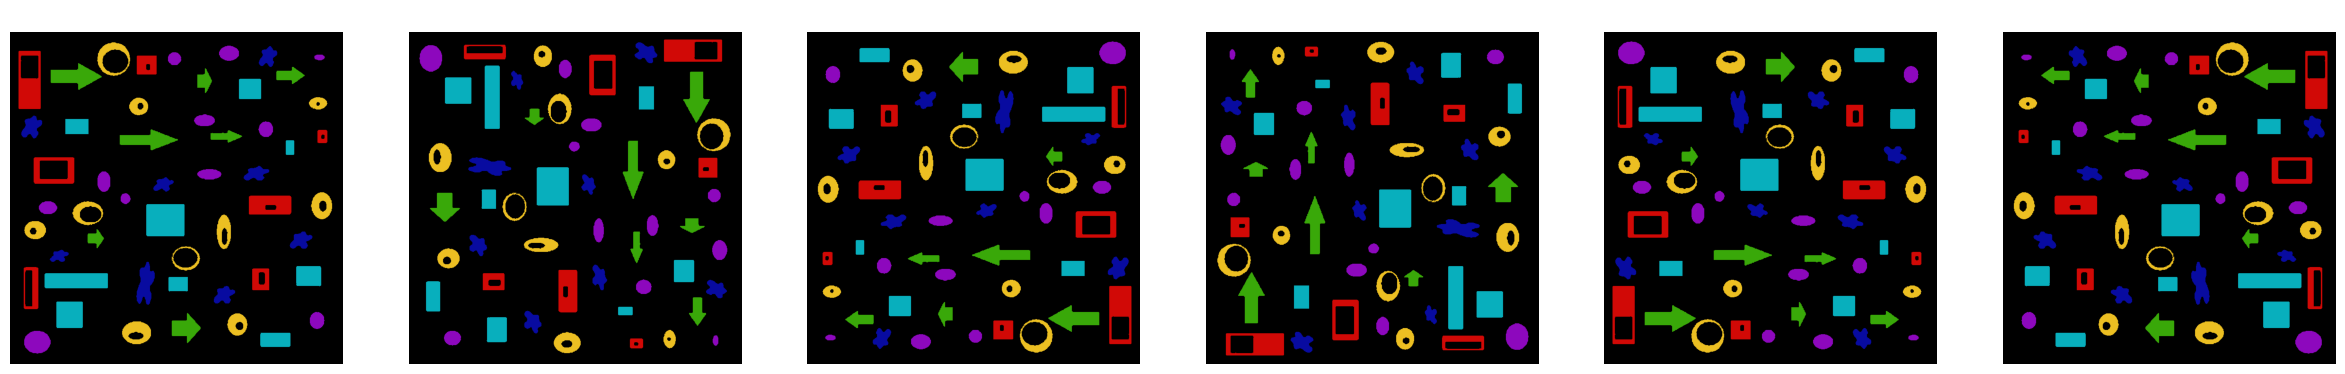

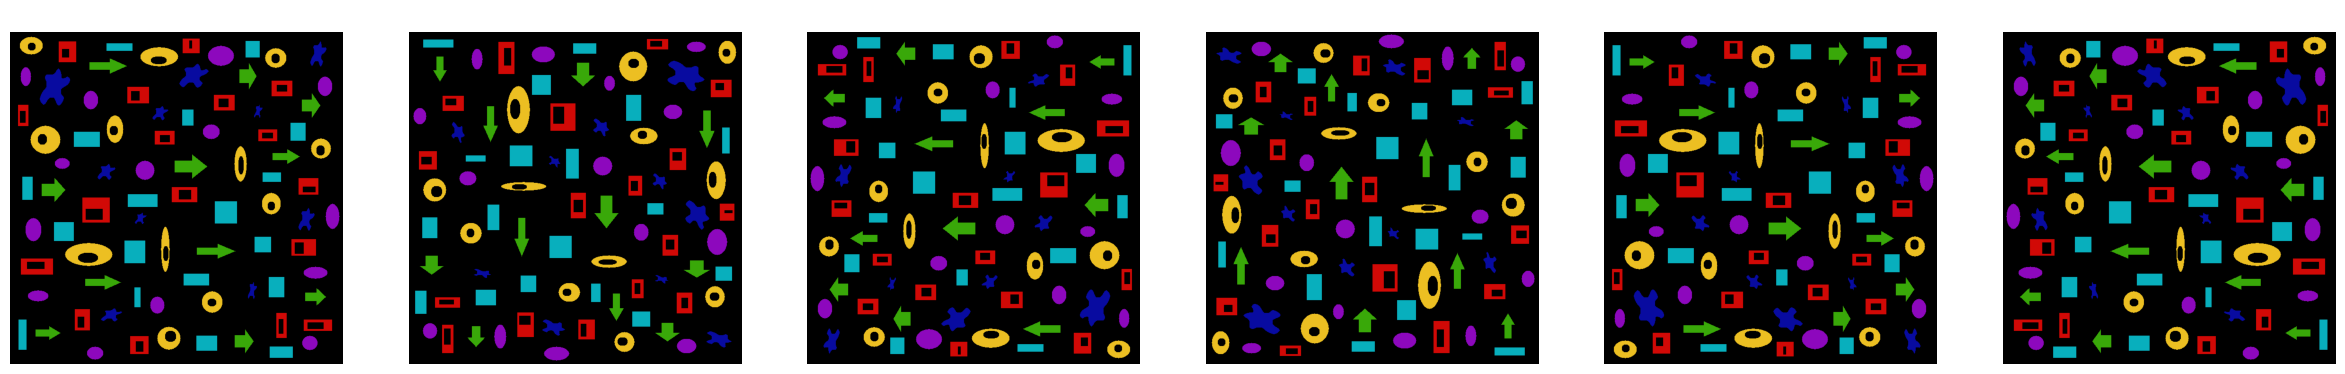

In [2]:
# przygotowanie zbioru danych, ekstrakcja danych uczących
img_train = cv2.imread("obiekty.png")
img_test = cv2.imread("obiekty2.png")
i = 0

for img in [img_train, img_test]:
  rotated1 = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
  rotated2 = cv2.rotate(img, cv2.ROTATE_180)
  rotated3 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  rotated4 = cv2.flip(img, 0)
  rotated5 = cv2.flip(img, 1)
  if i == 0:
    train_list = [img, rotated1, rotated2, rotated3, rotated4, rotated5]
    i+=1
  else:
    test_list = [img, rotated1, rotated2, rotated3, rotated4, rotated5]


polob(train_list, len(train_list))
polob(test_list, len(test_list))

Przygotowanie list obiektów, cech oraz klas dla całej listy obrazów treningowych

In [3]:
i = 0

for image in train_list:
  l, t = ekstrakcja_cech(image)
  k = ekstrakcja_klas(image)
  #print(t.shape)

  if i == 0:
    tc = t.copy()
    lo = l.copy()
    ka = k.copy()
    i += 1
  else:
    lo = np.append(lo, l)
    ka = np.append(ka, k)
    tc = np.vstack((tc, t))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
tc

array([[ 0.00000000e+00,  1.70500000e+03,  4.97000000e+03, ...,
        -1.90503480e+01, -1.29764153e+01,  1.89488111e+01],
       [ 1.00000000e+00,  1.05000000e+03,  1.34400000e+03, ...,
        -2.99390226e+01, -1.92385483e+01, -2.96072293e+01],
       [ 1.00000000e+00,  1.04100000e+03,  1.71600000e+03, ...,
        -2.44487415e+01,  1.58215917e+01,  2.39371111e+01],
       ...,
       [ 0.00000000e+00,  1.95100000e+03,  2.92800000e+03, ...,
        -2.29956440e+01, -1.49994393e+01, -2.39298023e+01],
       [ 1.00000000e+00,  2.11700000e+03,  2.68800000e+03, ...,
         3.13478784e+01,  2.05272448e+01, -3.12176425e+01],
       [ 1.00000000e+00,  1.90900000e+03,  1.92000000e+03, ...,
        -2.94362505e+01, -1.81237446e+01, -2.91313892e+01]])

In [5]:
i = 0

for image in test_list:
  l, t = ekstrakcja_cech(image)
  k = ekstrakcja_klas(image)
  #print(t.shape)

  if i == 0:
    tc_test = t.copy()
    lo_test = l.copy()
    ka_test = k.copy()
    i += 1
  else:
    lo_test = np.append(lo_test, l)
    ka_test = np.append(ka_test, k)
    tc_test = np.vstack((tc_test, t))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [6]:
tc_test

array([[ 0.00000000e+00,  1.18600000e+03,  1.82400000e+03, ...,
        -2.47512320e+01, -1.60185475e+01, -2.42870819e+01],
       [ 0.00000000e+00,  1.01400000e+03,  1.11600000e+03, ...,
        -2.50166902e+01, -1.63390940e+01, -2.48965722e+01],
       [ 1.00000000e+00,  1.05000000e+03,  1.05000000e+03, ...,
        -9.90000000e+01, -9.90000000e+01, -9.90000000e+01],
       ...,
       [ 0.00000000e+00,  1.13000000e+03,  1.48200000e+03, ...,
        -2.28878328e+01, -1.53752623e+01,  2.33241047e+01],
       [ 1.00000000e+00,  1.17600000e+03,  1.17600000e+03, ...,
        -9.90000000e+01, -9.90000000e+01, -9.90000000e+01],
       [ 1.00000000e+00,  7.28000000e+02,  9.52000000e+02, ...,
        -9.90000000e+01, -9.90000000e+01, -9.90000000e+01]])

In [7]:
print(len(lo), len(ka), tc.shape)

312 312 (312, 15)


In [25]:
print(len(lo_test), len(ka_test), tc_test.shape)

492 492 (492, 15)


Wyznaczane są następujące rodzaje cech dla wszystkich 6 obrazów wejściowych / treningowych (w ramach przypomnienia):

    0. liczba Eulera (EulerNumber) 
    1. Pole powierzchnie (Area)
    2. Pole powierzchni najmniejszego prostokąta (BoundingBoxArea)
    3. Pole powierzchni najmniejszego prostokąta z usuniętymi otworami (FilledArea)
    4. Stosunek pola powierchni obiektu od pola powierzchni najmniejszego prostokąta (Extent)
    5. Promień koła o powierzchni równej powierzechni obiektu (EquivDiameter)
    6. Stosunek pola powierchni obiektu od pola powierzchni jego powłoki wypukłej (Solidity)
    7. Pole powierzchni otworów w obiekcie
    8. Log momentu Hu1
    9. Log momentu Hu2
    10. Log momentu Hu3
    11. Log momentu Hu4
    12. Log momentu Hu5
    13. Log momentu Hu6
    14. Log momentu Hu7    

Prezentacja danych

klasa: 0  obiektów: 42


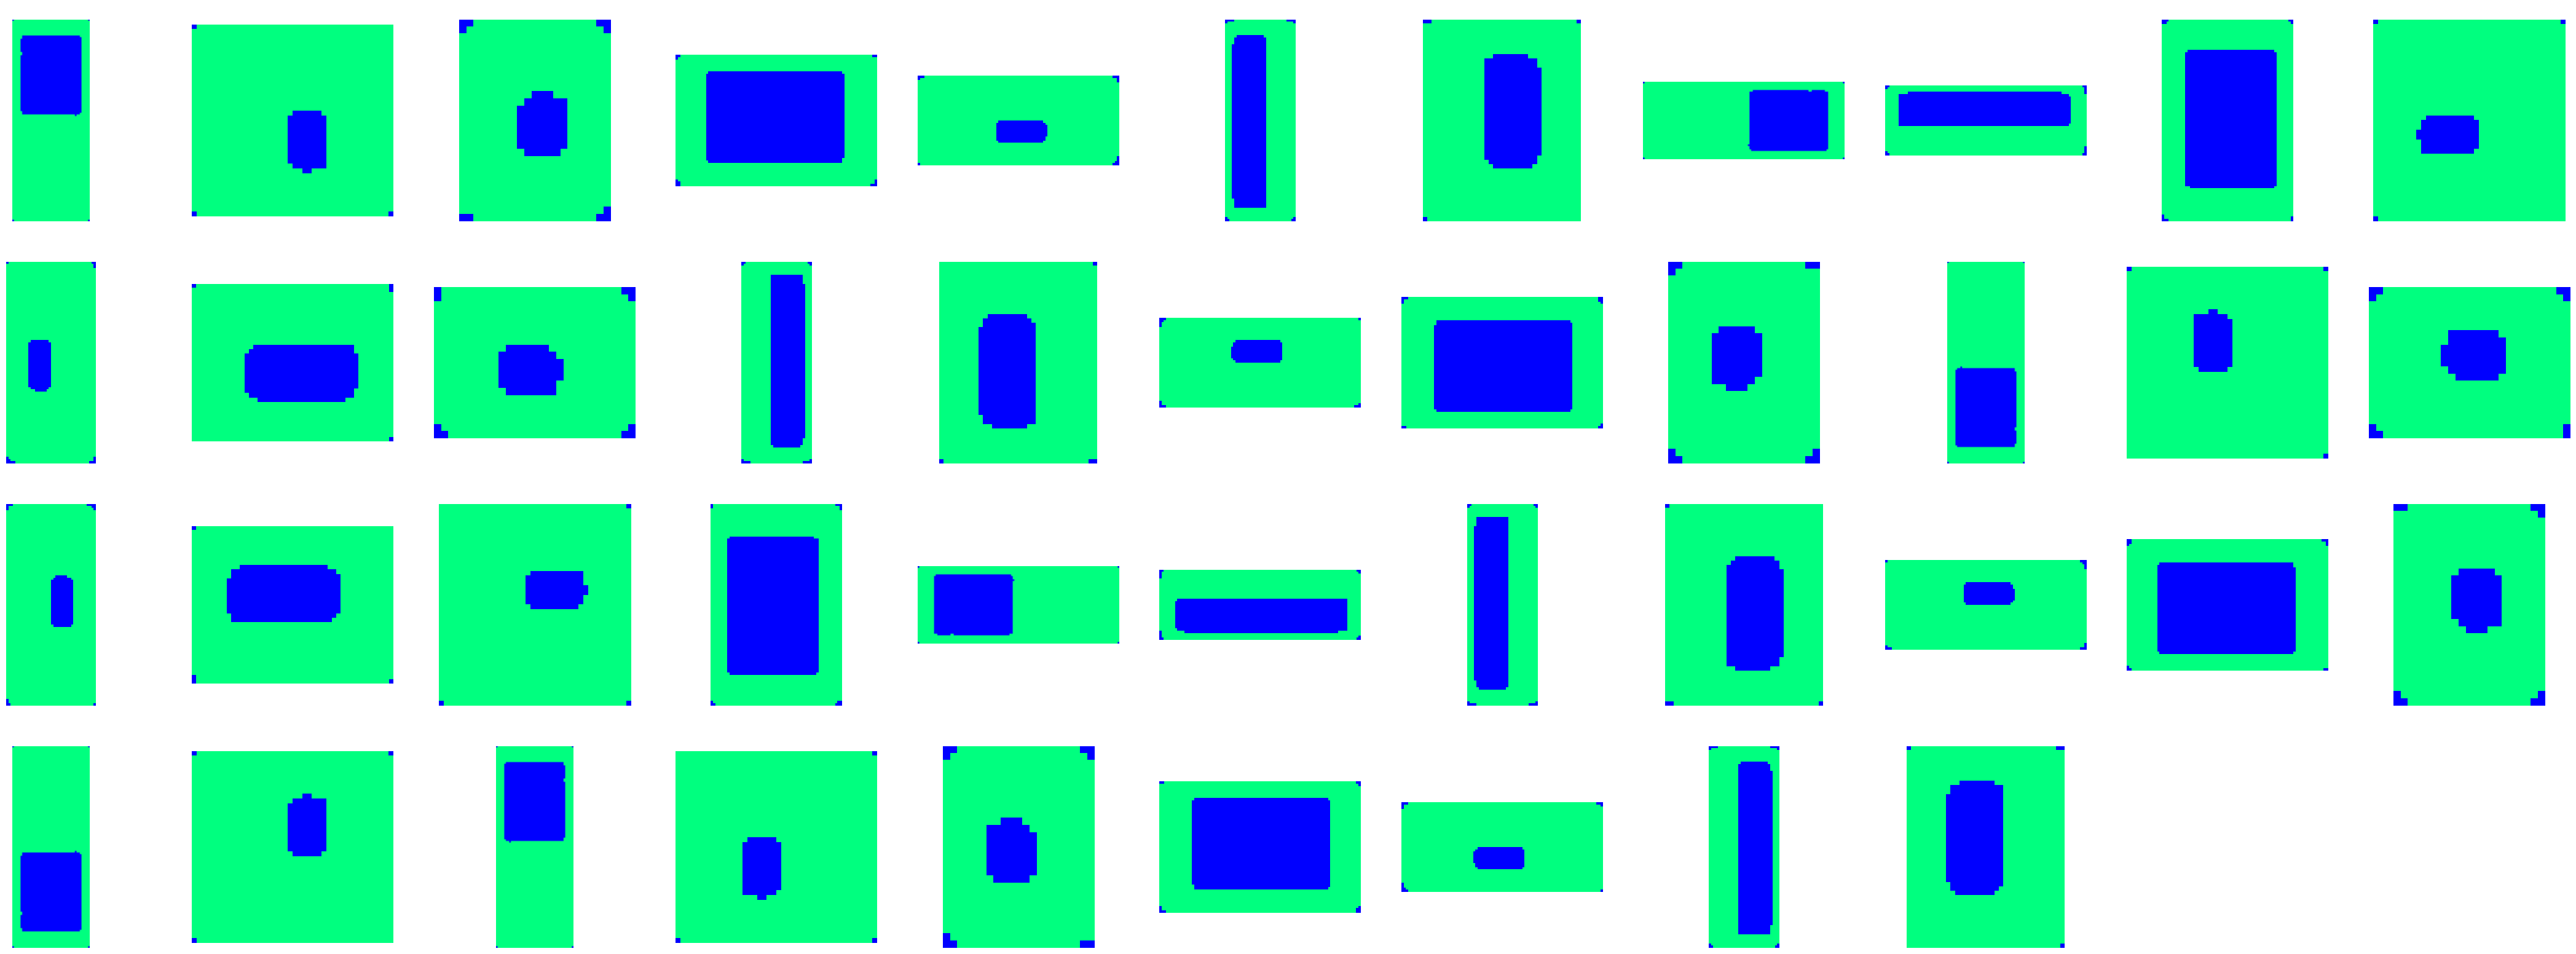

klasa: 1  obiektów: 42


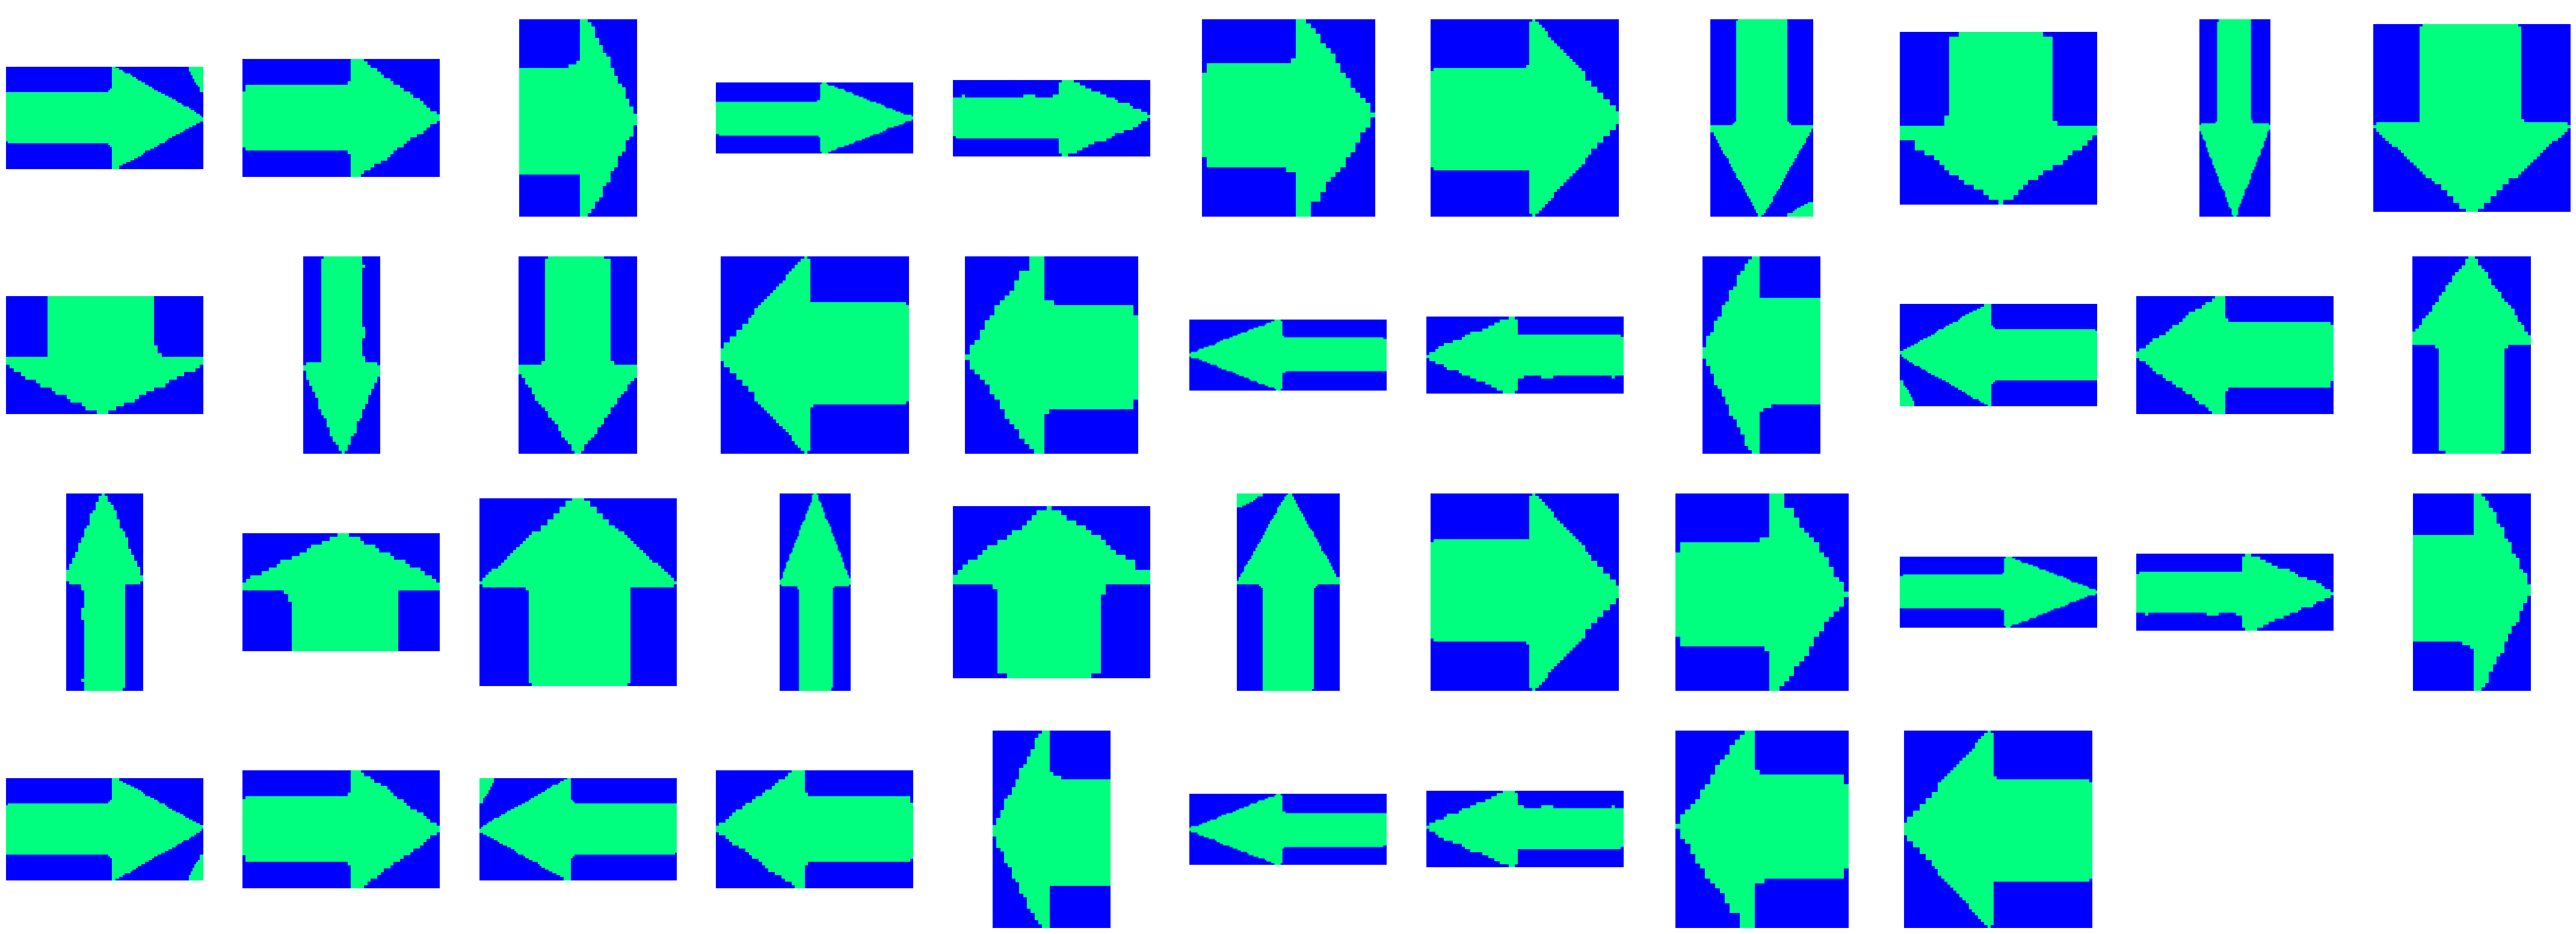

klasa: 2  obiektów: 60


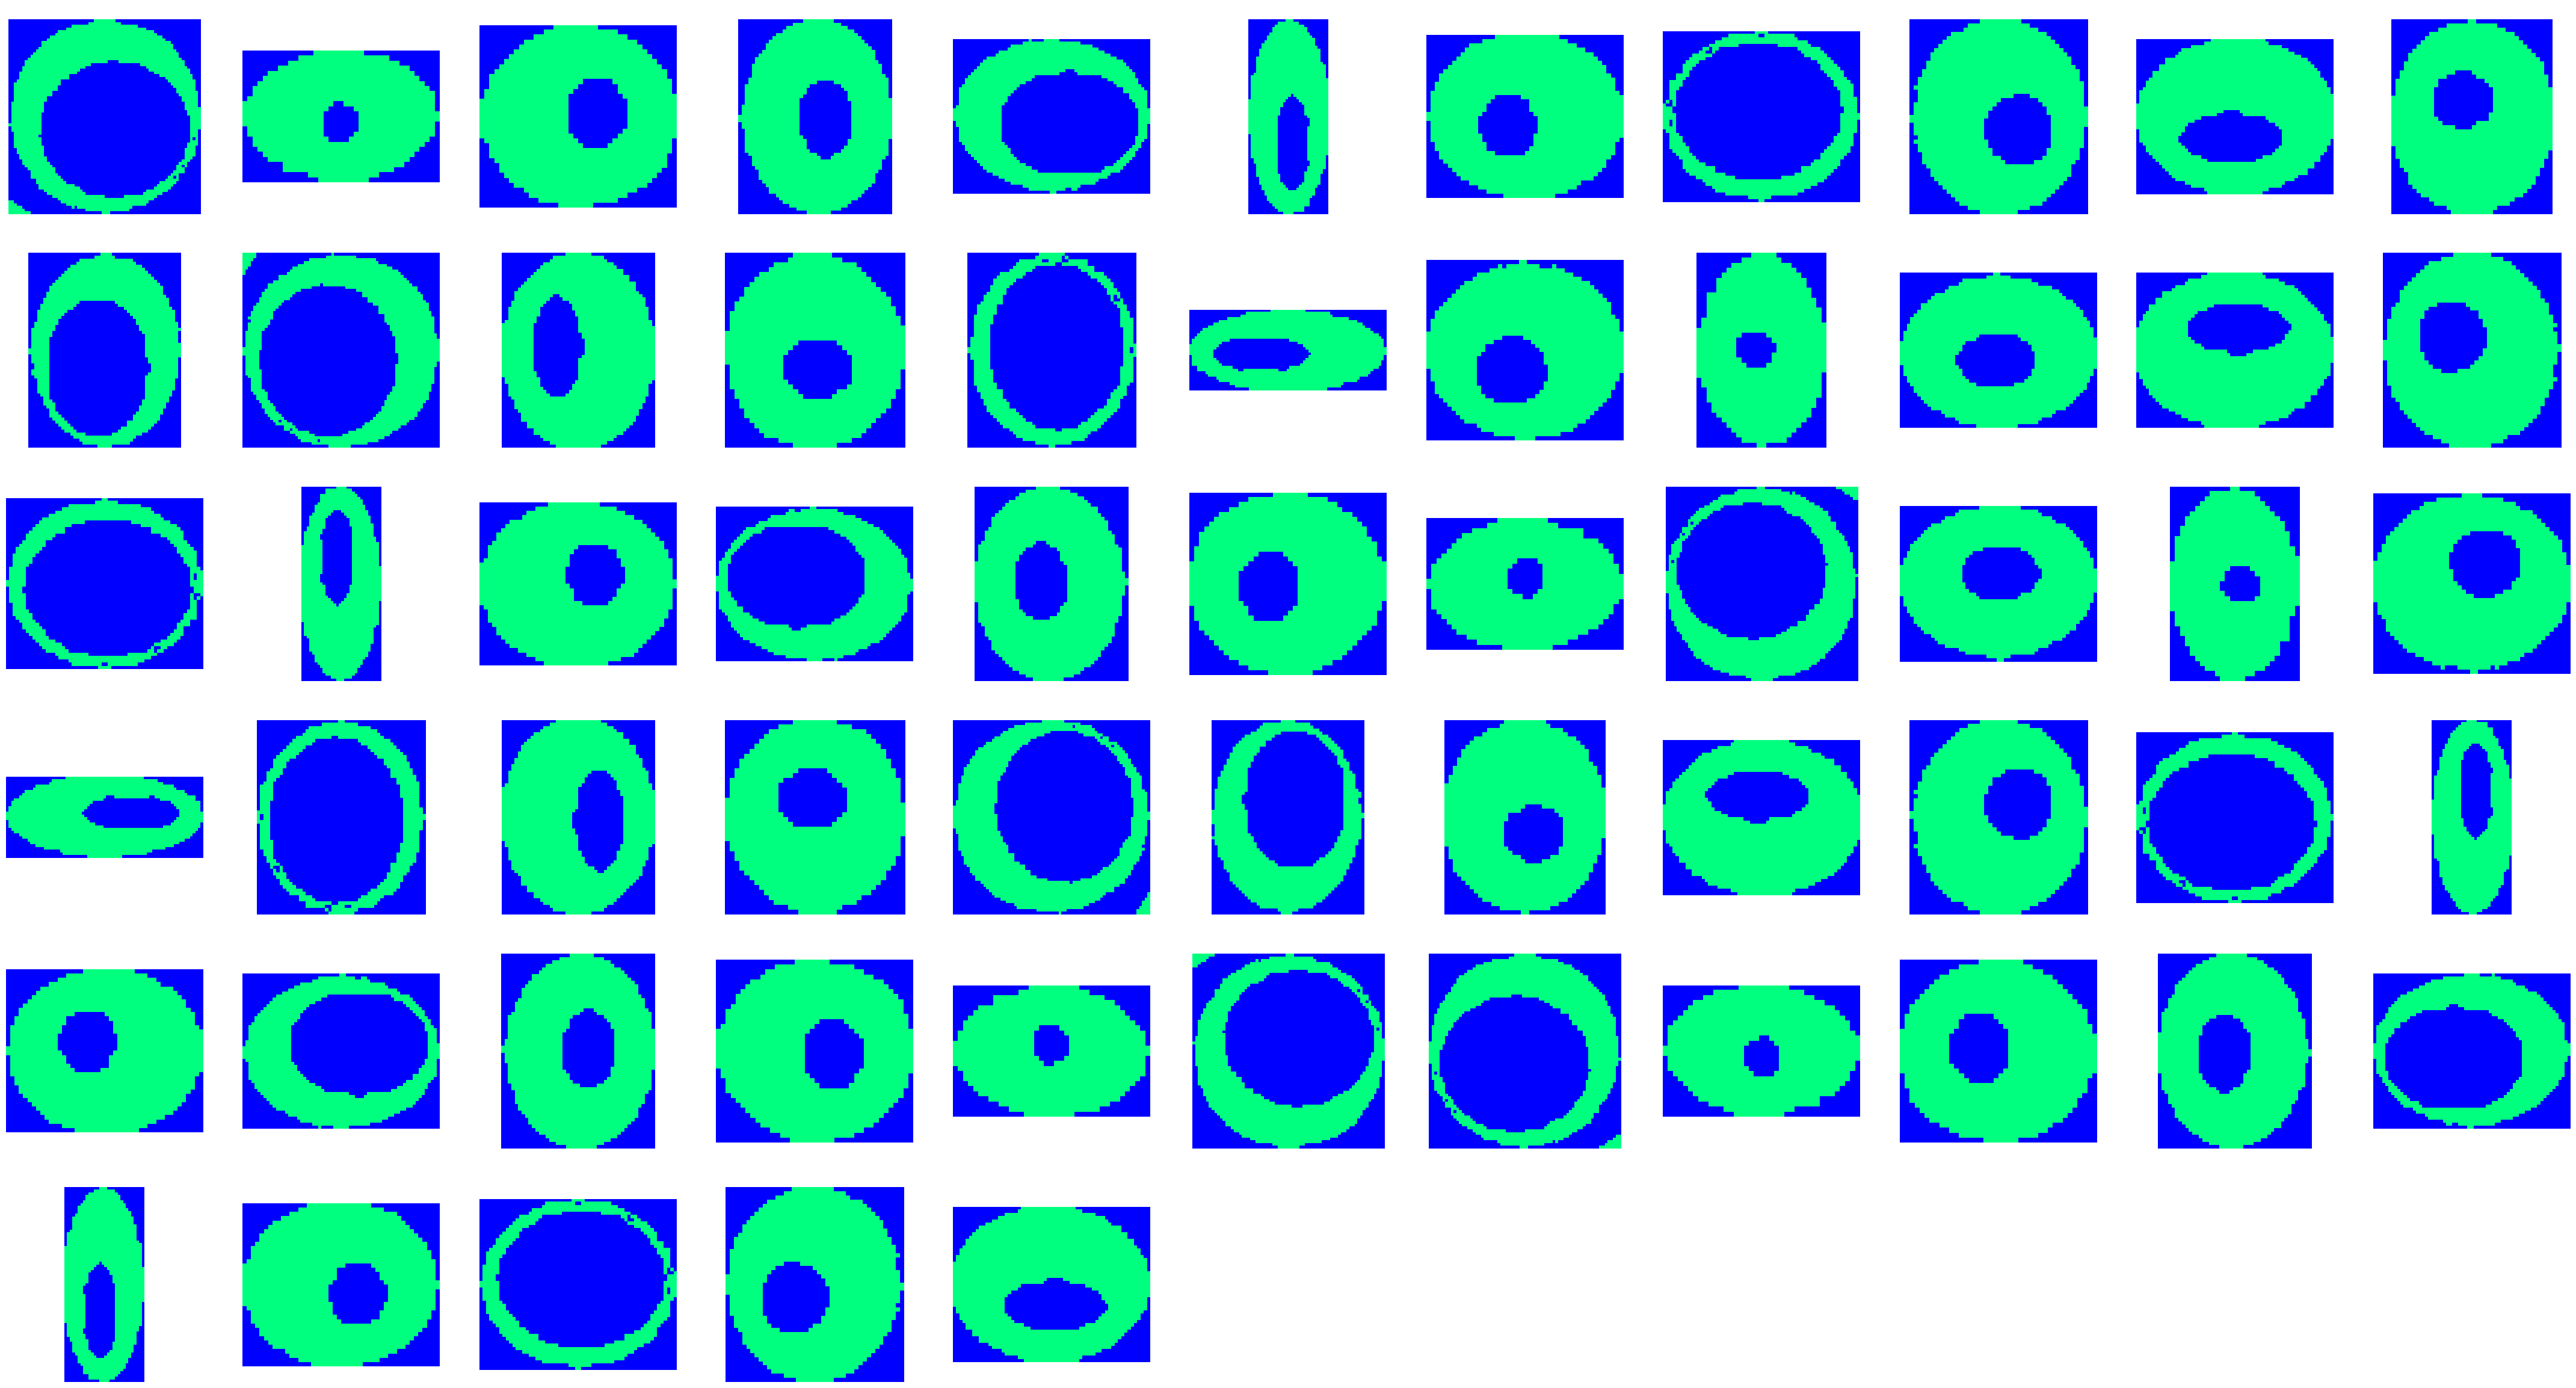

klasa: 3  obiektów: 48


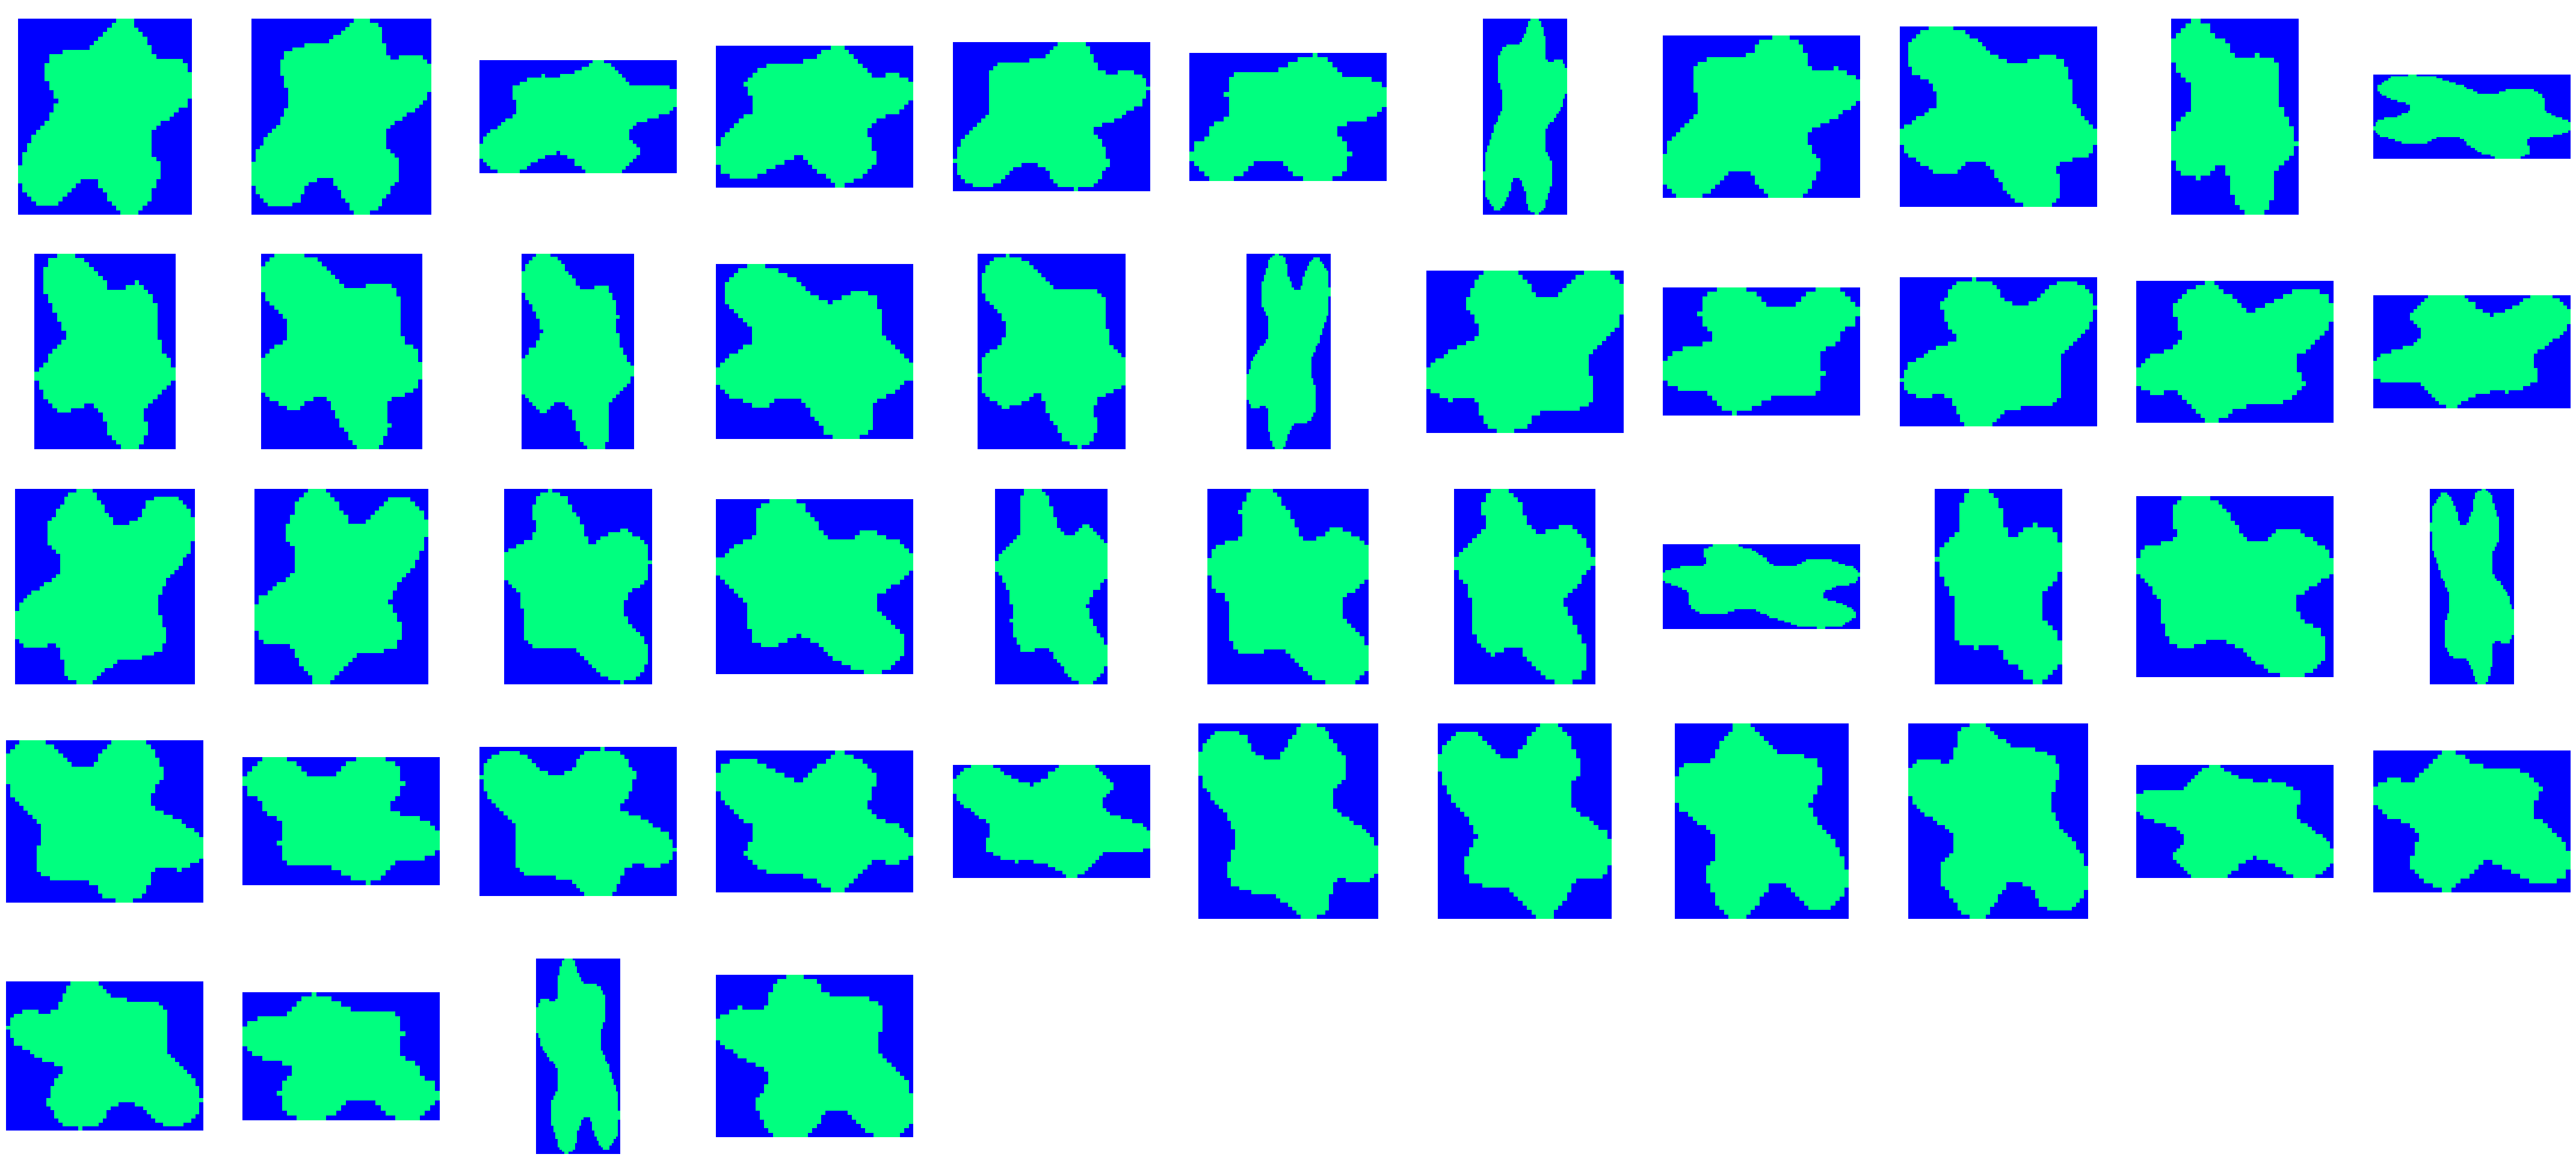

klasa: 4  obiektów: 66


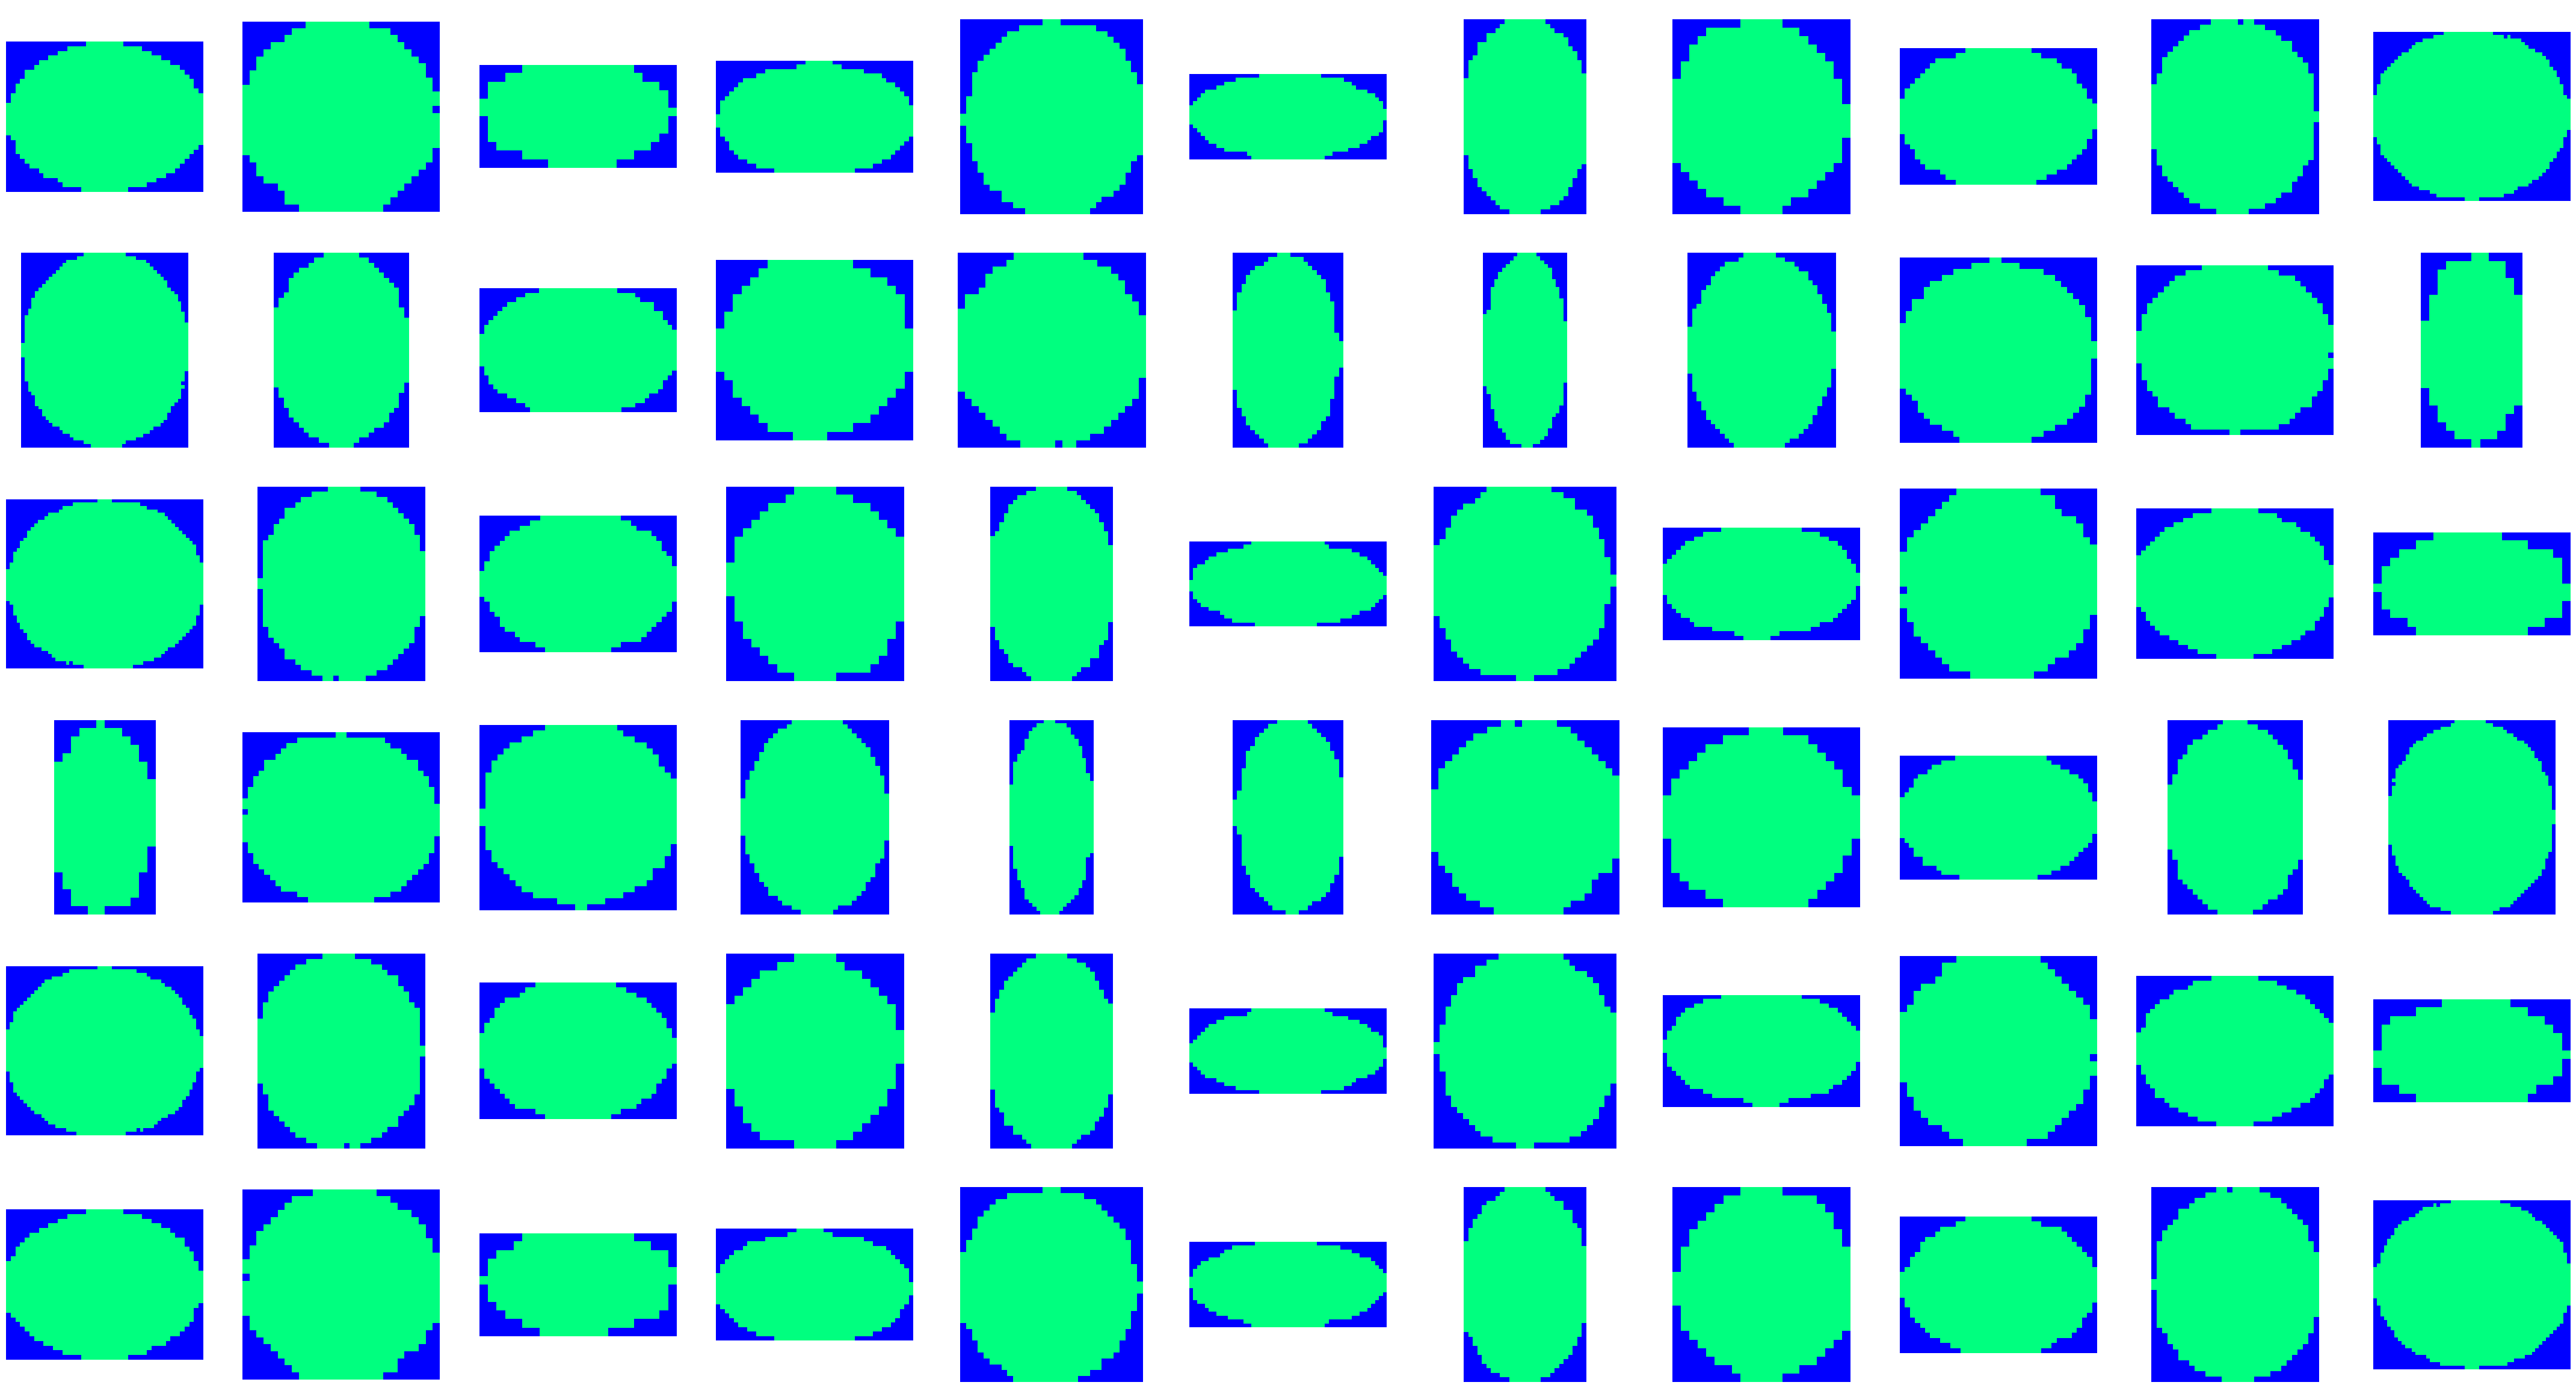

klasa: 5  obiektów: 54


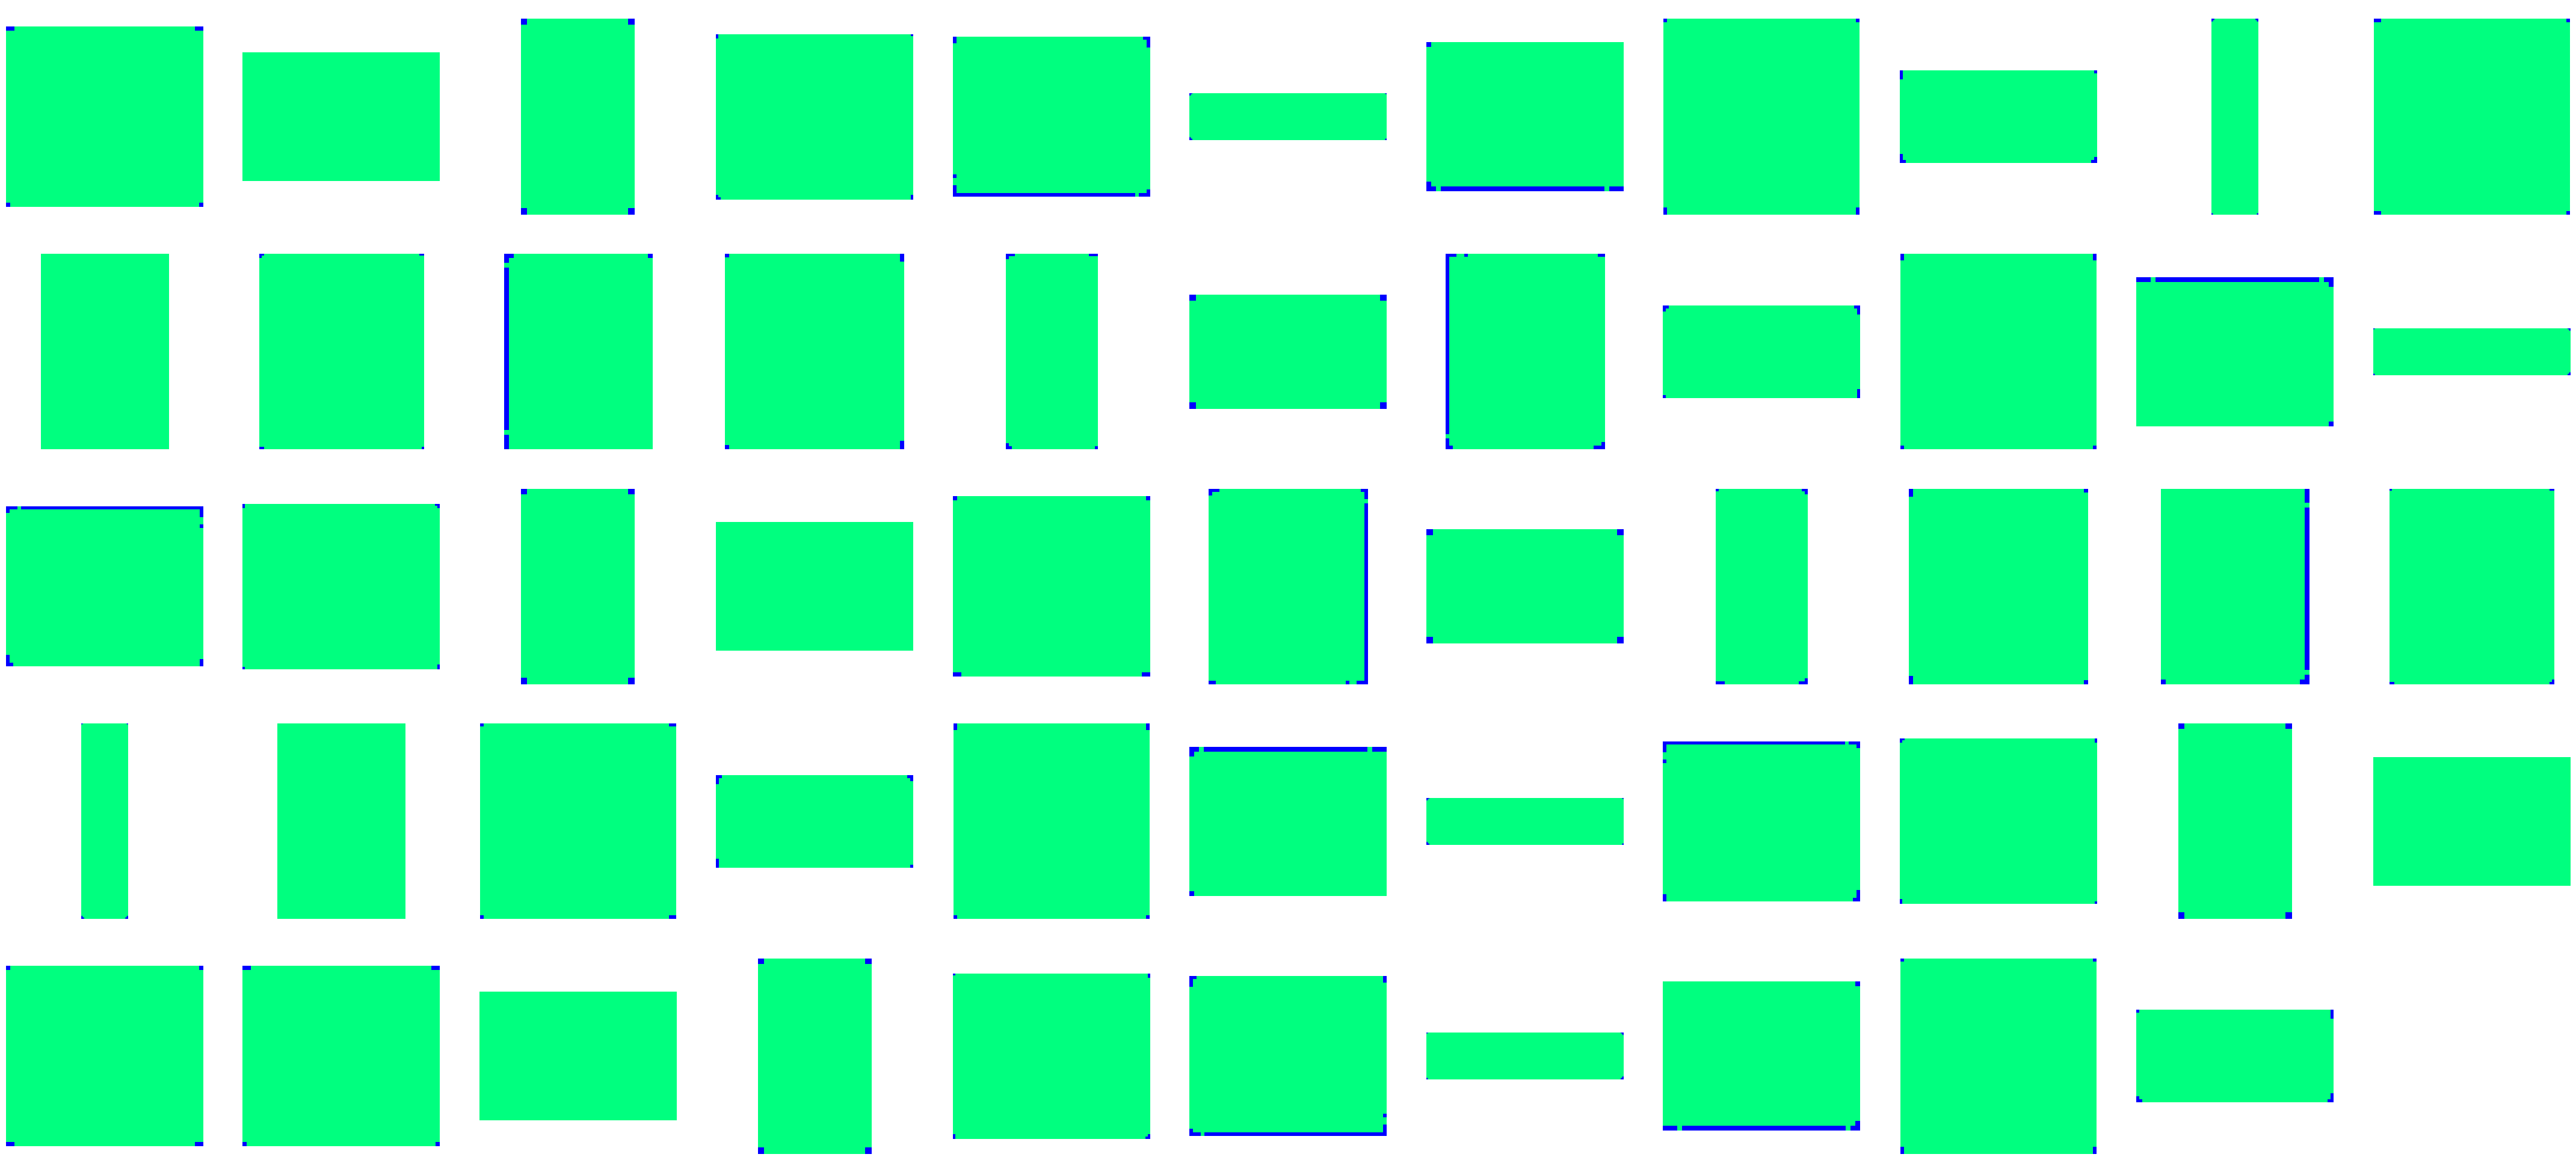

In [8]:
for j in range(6):
    lista_klasy = [lo[i] for i in np.where(ka == j)[0]]
    print("klasa:",j," obiektów:", len(lista_klasy))
    polob(lista_klasy,11,colmap='winter')

In [33]:
from itertools import combinations
lista = [i for i in range(15)]
lista

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

##Wybór oraz testy klasyfikatora

In [34]:
# model klasyfikatora
wybrane_cechy = [0,]
wc = wybierz(tc,wybrane_cechy)

modele = {"Drzewo" : DecisionTreeClassifier(random_state=0), "Sasiedzi" : KNeighborsClassifier(n_neighbors=3), "Najblizszego centrum" : NearestCentroid(), "Naiwny gaussa" : GaussianNB()}

In [35]:
#Wykonalem automatyczne wyszukiwanie najlepszych cech dla roznych klasyfikatorow by wybrać najlepszą parę dla tego problemu, sprawdzajac wszystkie możliwe kombinacje oraz zapisujac najlepsze wyniki
ilosc_iteracji = 0
best_nazwa = ""
best_wynik_train, best_wynik_test = 0, 0
najlepsze_cechy = []

for i in range(15):
  comb = list(combinations(lista, i))

  for i in list(comb):
    if len(i) == 0:
      break
    wybrane_cechy = i
    wc = wybierz(tc,wybrane_cechy)
    for nazwa, model in modele.items():
      ilosc_iteracji += 1
      # uczenie klasyfikatora
      model.fit(wc,np.ravel(ka))
      klasy_przewidywane = model.predict(wc)

      # weryfikacja na zbiorze uczącym
      wc2 = wybierz(tc_test,wybrane_cechy)
      klasy_przewidywane2 = model.predict(wc2)
      mp = confusion_matrix(klasy_przewidywane,ka)
      wynik_train = np.sum(np.diag(mp))/np.sum(mp)
      #print(nazwa + ": macierz pomyłek - zbiór uczący, dokładność:", wynik_train)
      #print(mp)


      mp2 = confusion_matrix(klasy_przewidywane2,ka_test)
      wynik_test = np.sum(np.diag(mp2))/np.sum(mp2)
      #print(nazwa + ": macierz pomyłek - zbiór testowy, dokładność:", wynik_test)
      #print(mp2)

      # najbardziej zalezy mi na najlepszej generalizacji
      if (wynik_test > best_wynik_test):
        best_wynik_train = wynik_train
        best_wynik_test = wynik_test
        best_nazwa = nazwa
        najlepsze_cechy = wybrane_cechy
        if wynik_test > 0.97:
          break
      
      print("Mamy " + str(ilosc_iteracji) + " iteracje")

print("Zwyciezcą konkursu zostaje: " + best_nazwa + " o dokładności predykcji na zbiorze uczącym: " + str(round(best_wynik_train * 100, 2)) + "% oraz testującym " + str(round(best_wynik_test * 100, 2)) + "%")
print(najlepsze_cechy)



Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Mamy 126067 iteracje
Mamy 126068 iteracje
Mamy 126069 iteracje
Mamy 126070 iteracje
Mamy 126071 iteracje
Mamy 126072 iteracje
Mamy 126073 iteracje
Mamy 126074 iteracje
Mamy 126075 iteracje
Mamy 126076 iteracje
Mamy 126077 iteracje
Mamy 126078 iteracje
Mamy 126079 iteracje
Mamy 126080 iteracje
Mamy 126081 iteracje
Mamy 126082 iteracje
Mamy 126083 iteracje
Mamy 126084 iteracje
Mamy 126085 iteracje
Mamy 126086 iteracje
Mamy 126087 iteracje
Mamy 126088 iteracje
Mamy 126089 iteracje
Mamy 126090 iteracje
Mamy 126091 iteracje
Mamy 126092 iteracje
Mamy 126093 iteracje
Mamy 126094 iteracje
Mamy 126095 iteracje
Mamy 126096 iteracje
Mamy 126097 iteracje
Mamy 126098 iteracje
Mamy 126099 iteracje
Mamy 126100 iteracje
Mamy 126101 iteracje
Mamy 126102 iteracje
Mamy 126103 iteracje
Mamy 126104 iteracje
Mamy 126105 iteracje
Mamy 126106 iteracje
Mamy 126107 iteracje
Mamy 126108 iteracje
Mamy 126109 iteracje
Mamy 126110 iteracje
Mamy 126111

In [21]:
print("Zwyciezcą konkursu zostaje: " + best_nazwa + " o dokładności predykcji na zbiorze uczącym: " + str(round(best_wynik_train * 100, 2)) + "% oraz testującym " + str(round(best_wynik_test * 100, 2)) + "%")
wybrane_cechy = najlepsze_cechy
print(najlepsze_cechy)
wybrane_cechy = []

Zwyciezcą konkursu zostaje: Naiwny gaussa o dokładności predykcji na zbiorze uczącym: 100.0% oraz testującym 95.12%
(0, 7, 12)


Naiwny gaussa: macierz pomyłek - zbiór uczący, dokładność: 1.0
[[42  0  0  0  0  0]
 [ 0 42  0  0  0  0]
 [ 0  0 60  0  0  0]
 [ 0  0  0 48  0  0]
 [ 0  0  0  0 66  0]
 [ 0  0  0  0  0 54]]
Naiwny gaussa: macierz pomyłek - zbiór testowy, dokładność: 0.9512195121951219
[[102   0   0   0   0   0]
 [  0  60   0  18   0   0]
 [  0   0  72   0   0   0]
 [  0   6   0  42   0   0]
 [  0   0   0   0  84   0]
 [  0   0   0   0   0 108]]
Obrazy, które zostały fałszywie sklasyfikowane, ilosc: 24


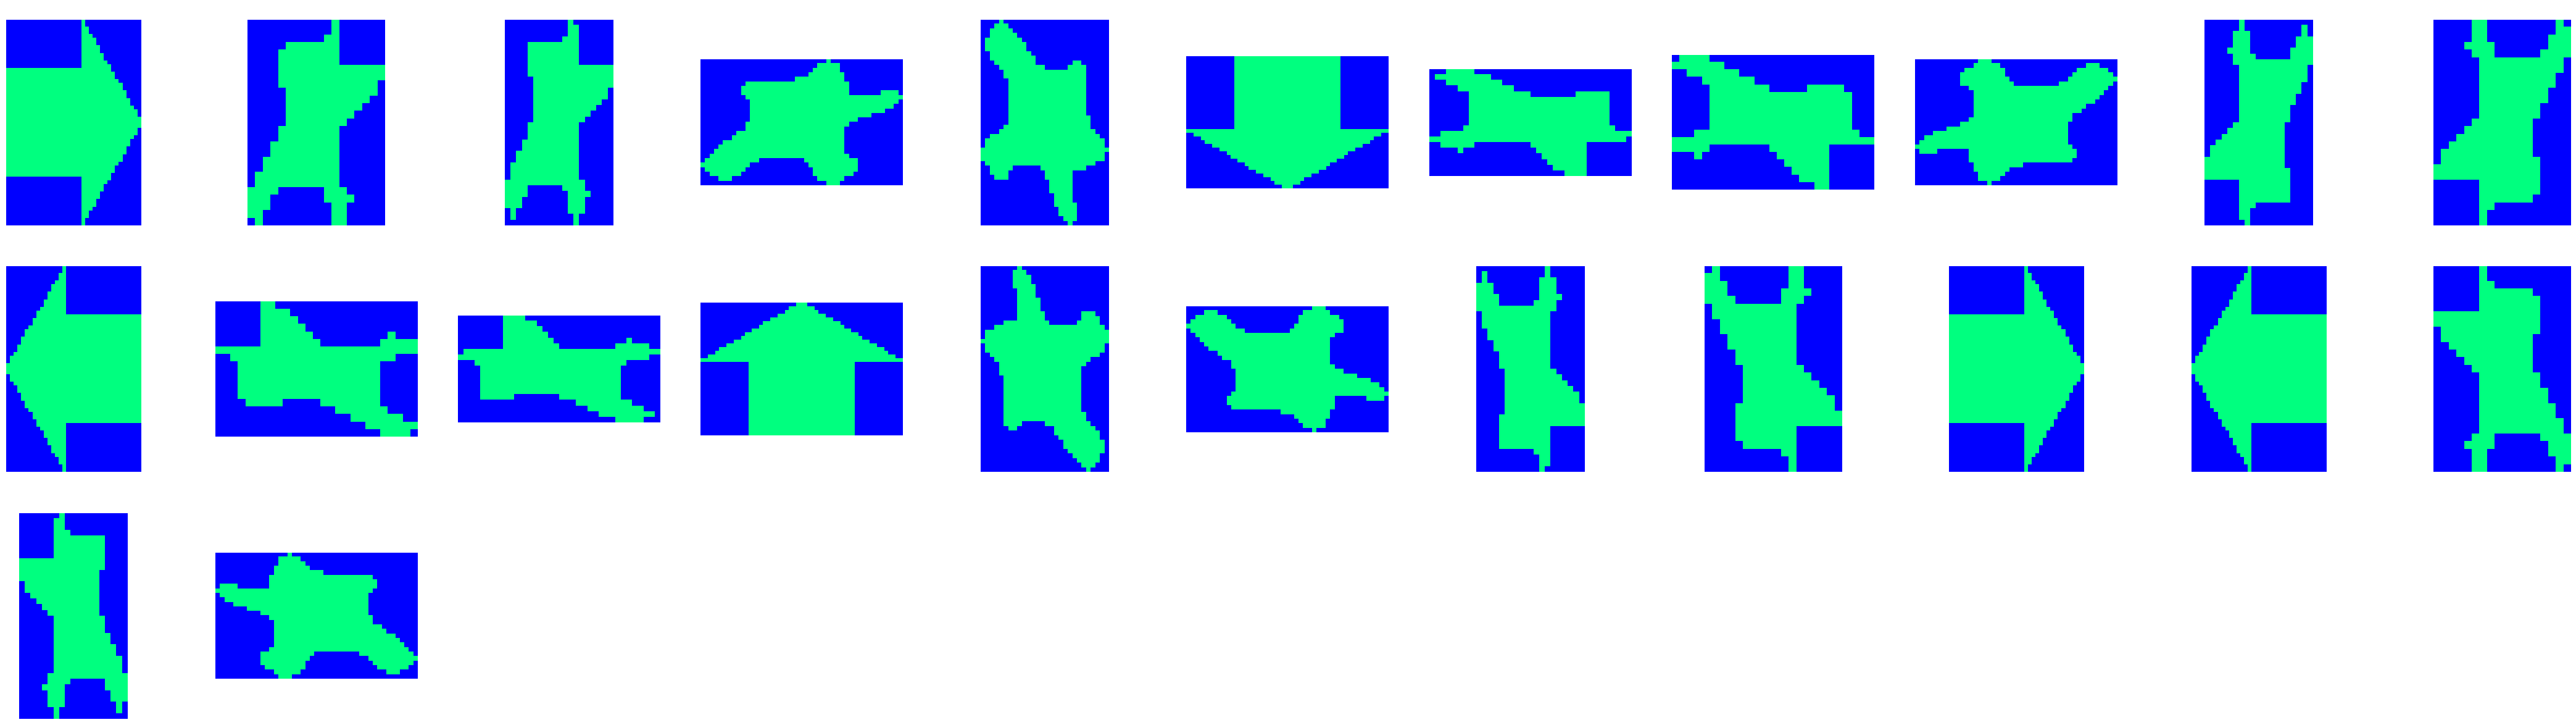

In [39]:
model = modele[best_nazwa]

# trenowanie najlepszego modelu
wc = wybierz(tc,najlepsze_cechy)
model.fit(wc,np.ravel(ka))
klasy_przewidywane = model.predict(wc)

# weryfikacja na zbiorze uczącym
wc2 = wybierz(tc_test,najlepsze_cechy)
klasy_przewidywane2 = model.predict(wc2)

mp = confusion_matrix(klasy_przewidywane,ka)
wynik_train = np.sum(np.diag(mp))/np.sum(mp)
print(best_nazwa + ": macierz pomyłek - zbiór uczący, dokładność:", wynik_train)
print(mp)

mp2 = confusion_matrix(klasy_przewidywane2,ka_test)
wynik_test = np.sum(np.diag(mp2))/np.sum(mp2)
print(best_nazwa + ": macierz pomyłek - zbiór testowy, dokładność:", wynik_test)
print(mp2)

#print(klasy_przewidywane2)
#print(ka_test)

i = 0
indexes_list = []
obrazy_list = []

for item in range(len(ka_test)):
  if klasy_przewidywane2[item] != ka_test[item]:
    indexes_list.append(item)
    obrazy_list.append(lo_test[item])

print("Obrazy, które zostały fałszywie sklasyfikowane, ilosc: " + str(len(obrazy_list)))
polob(obrazy_list, 11,colmap='winter')


Uzyskana dokładność na zbiorze testowym wynosi:

# 95.12%

Liczba parametrów modelu (wag) wynosi:

# XXXXX


Wnioski:
*   Bardzo przydatne przy obróconych kształtach okazały się momenty Hu - wskaźniki te są bardzo mało czułe na obroty oraz odbicia - źródło: https://learnopencv.com/shape-matching-using-hu-moments-c-python/
* W wyniku przetestowania różnych klasyfikatorów wybrany został ten o najwyższych zdolnościach generalizujących.
* Okazało się, że wcale nie potrzeba było wybierać dużej ilości cech obrazów, wybrane 3 cechy pozwoliły na zaskakująco świetne wyniki predykcji na zbiorze testowym .
* Najlepsze cehcy: [0, 7, 12]
* Najlepszy klasyfikator: GaussianNB()

---
---
Historia zmian:
* wersja r.akad 21/22 8.12.2021 (MI)